In [1]:
# Import necessary libraries
import requests
import zipfile
import tarfile
import os
import random
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Download the Yelp JSON zip file
url = "https://business.yelp.com/external-assets/files/Yelp-JSON.zip"
filename = "Yelp-JSON.zip"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
response = requests.get(url, stream=True, headers=headers)
response.raise_for_status()
with open(filename, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)
print(f"Downloaded {filename} successfully.")

# Unzip the downloaded file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(".")
print("Extracted Yelp-JSON.zip successfully.")

# Extract the tar file
tar_file = "Yelp JSON/yelp_dataset.tar"
with tarfile.open(tar_file, 'r') as tar_ref:
    tar_ref.extractall(".")
print("Extracted yelp_dataset.tar successfully.")

# Define paths to JSON files
business_file = 'yelp_academic_dataset_business.json'
review_file = 'yelp_academic_dataset_review.json'
user_file = 'yelp_academic_dataset_user.json'

# Sampling rates
sample_rate_business = 0.50  # 50% for business
sample_rate_large = 0.10     # 10% for review and user

# Sample and load business
sampled_business_lines = []
with open(business_file, 'r', encoding='utf-8') as f:
    for line in f:
        if random.random() < sample_rate_business:
            sampled_business_lines.append(line)
df_business = pd.read_json(io.StringIO(''.join(sampled_business_lines)), lines=True)

# Sample and load review
sampled_review_lines = []
with open(review_file, 'r', encoding='utf-8') as f:
    for line in f:
        if random.random() < sample_rate_large:
            sampled_review_lines.append(line)
df_review = pd.read_json(io.StringIO(''.join(sampled_review_lines)), lines=True)

# Sample and load user
sampled_user_lines = []
with open(user_file, 'r', encoding='utf-8') as f:
    for line in f:
        if random.random() < sample_rate_large:
            sampled_user_lines.append(line)
df_user = pd.read_json(io.StringIO(''.join(sampled_user_lines)), lines=True)

print("DataFrames loaded successfully.")

Downloaded Yelp-JSON.zip successfully.
Extracted Yelp-JSON.zip successfully.


/tmp/ipython-input-538624752.py:34: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_ref.extractall(".")


Extracted yelp_dataset.tar successfully.
DataFrames loaded successfully.


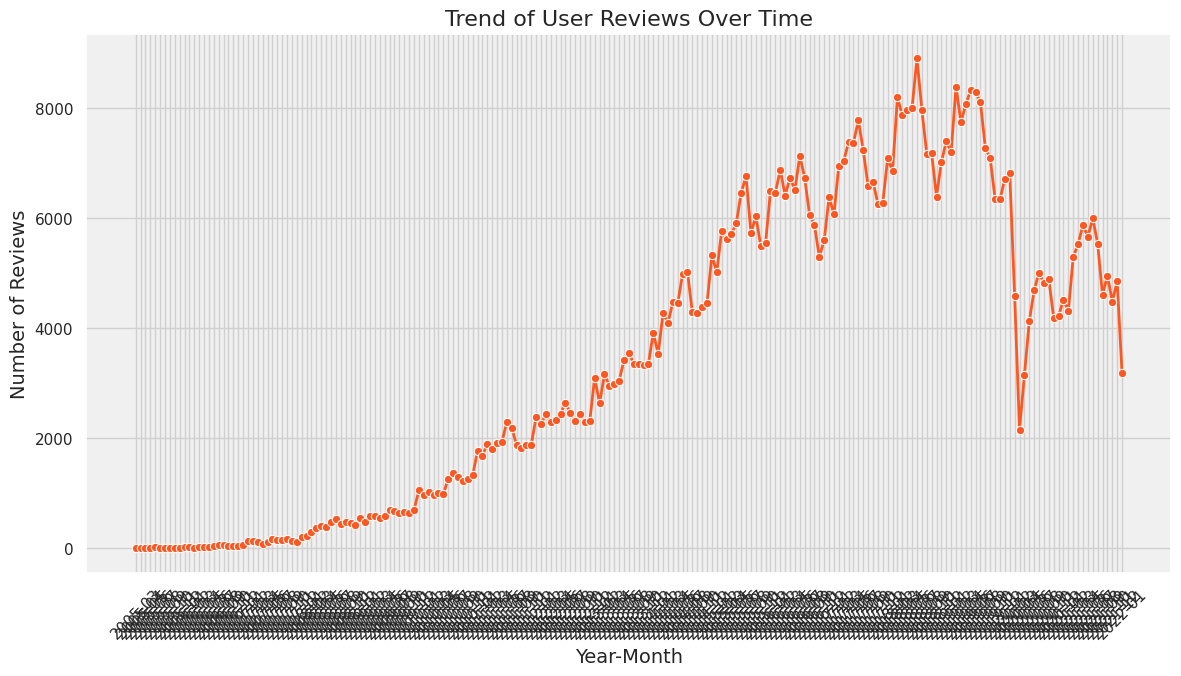

In [2]:
# سناریو ۱: Line Chart - روند فعالیت کاربران
plt.figure(figsize=(14,7))
sns.set(style='darkgrid', rc={'axes.facecolor':'#f0f0f0', 'grid.color':'#d0d0d0'})
df_review['date'] = pd.to_datetime(df_review['date'])
df_review['year_month'] = df_review['date'].dt.to_period('M').astype(str)
monthly_reviews = df_review.groupby('year_month').size().reset_index(name='count')
sns.lineplot(x='year_month', y='count', data=monthly_reviews, marker='o', color='#FF5722', linewidth=2)
plt.title('Trend of User Reviews Over Time', fontsize=16)
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45)
plt.show()

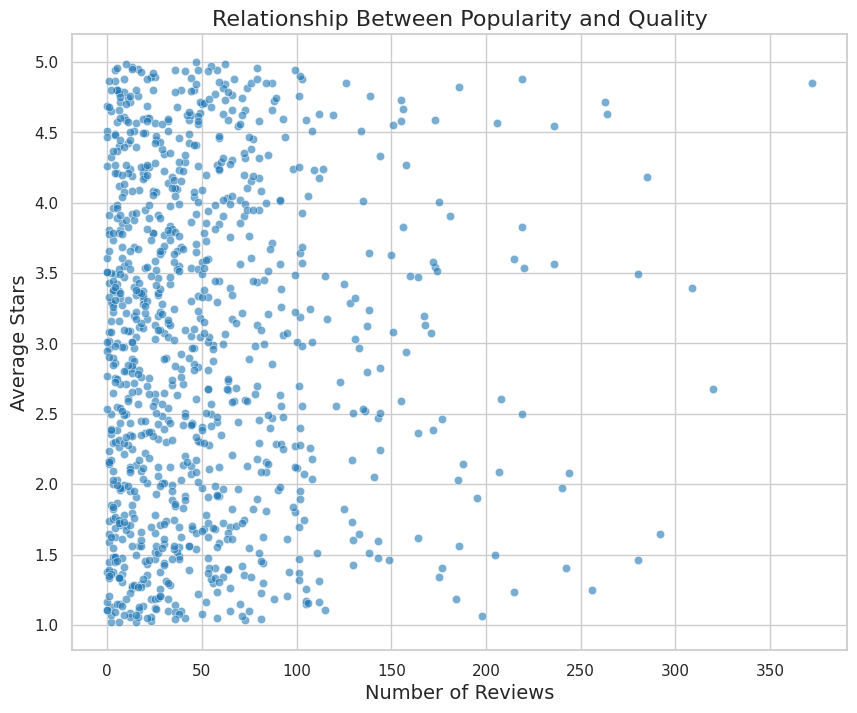

In [25]:
# سناریو ۲: Scatter Plot - رابطه محبوبیت و کیفیت
plt.figure(figsize=(10,8))
sns.set(style='whitegrid')
sns.scatterplot(x='review_count', y='stars', data=df_business, color='#1f77b4', alpha=0.6)
plt.title('Relationship Between Popularity and Quality', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=14)
plt.ylabel('Average Stars', fontsize=14)
plt.show()

<Figure size 1400x700 with 0 Axes>

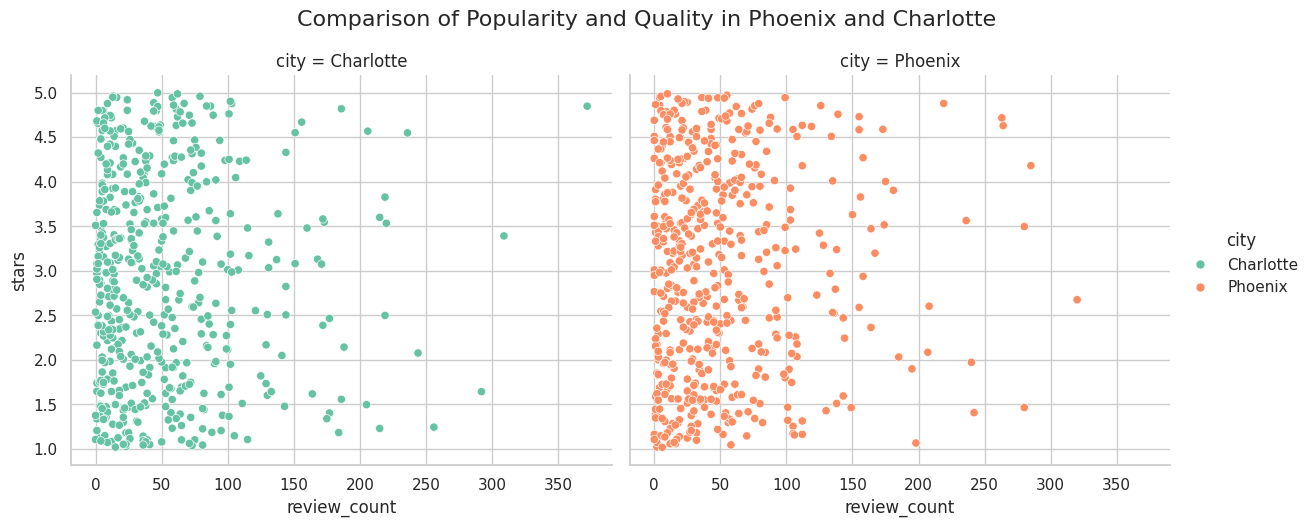

In [26]:
# سناریو ۳: Rel Plot - مقایسه رابطه بین دو شهر
plt.figure(figsize=(14,7))
cities = df_business[df_business['city'].isin(['Phoenix', 'Charlotte'])]
sns.relplot(x='review_count', y='stars', data=cities, kind='scatter', col='city', hue='city', palette='Set2', height=5, aspect=1.2)
plt.suptitle('Comparison of Popularity and Quality in Phoenix and Charlotte', y=1.05, fontsize=16)
plt.show()

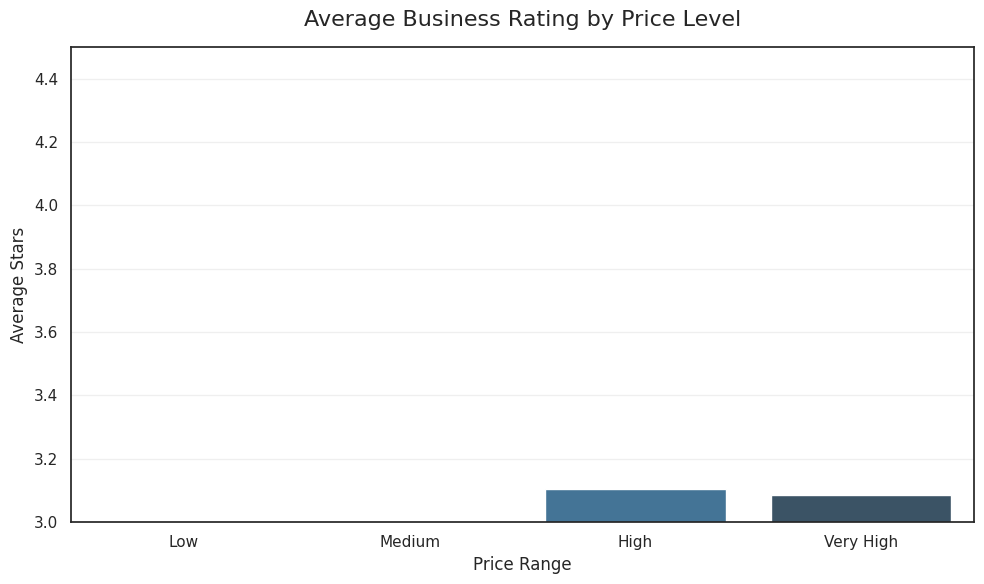

In [52]:
# سناریو ۴: Bar Plot - مقایسه کیفیت بر اساس قیمت
df_rest = df_business[df_business['categories'].str.contains('Restaurant|Food', case=False, na=False)].copy()
price = df_rest['attributes'].apply(lambda x: x.get('RestaurantsPriceRange2') if isinstance(x, dict) else None)
if price.notna().sum() < 10:
    df_rest['price'] = pd.qcut(df_rest['review_count'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
else:
    df_rest['price'] = price.map({'1':'Low', '2':'Medium', '3':'High', '4':'Very High'}).fillna('Medium')
plt.figure(figsize=(10, 6))
sns.barplot(data=df_rest, x='price', y='stars', hue='price', order=['Low', 'Medium', 'High', 'Very High'],
            palette='Blues_d', errorbar=None, legend=False)
plt.title('Average Business Rating by Price Level', fontsize=16, pad=15)
plt.xlabel('Price Range')
plt.ylabel('Average Stars')
plt.ylim(3, 4.5)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1209713274.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stars', data=df_review, palette='viridis')


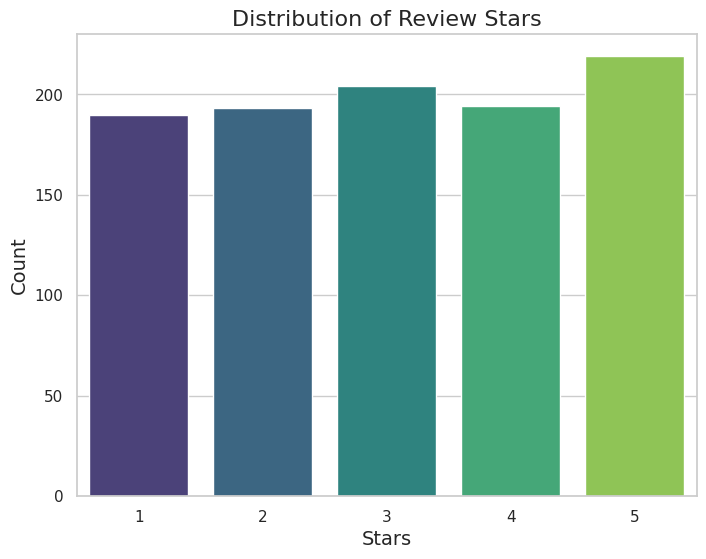

In [35]:
# سناریو ۵: Count Plot - توزیع امتیازهای کاربران
plt.figure(figsize=(8,6))
sns.set(style='whitegrid')
sns.countplot(x='stars', data=df_review, palette='viridis')
plt.title('Distribution of Review Stars', fontsize=16)
plt.xlabel('Stars', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

Number of reviews in selected categories: 669
Distribution of categories:
category_group
Restaurants    348
Shopping       321
Name: count, dtype: int64


/tmp/ipython-input-3745861939.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=filtered, x='stars', col='category_group', kind='count',


<Figure size 1500x600 with 0 Axes>

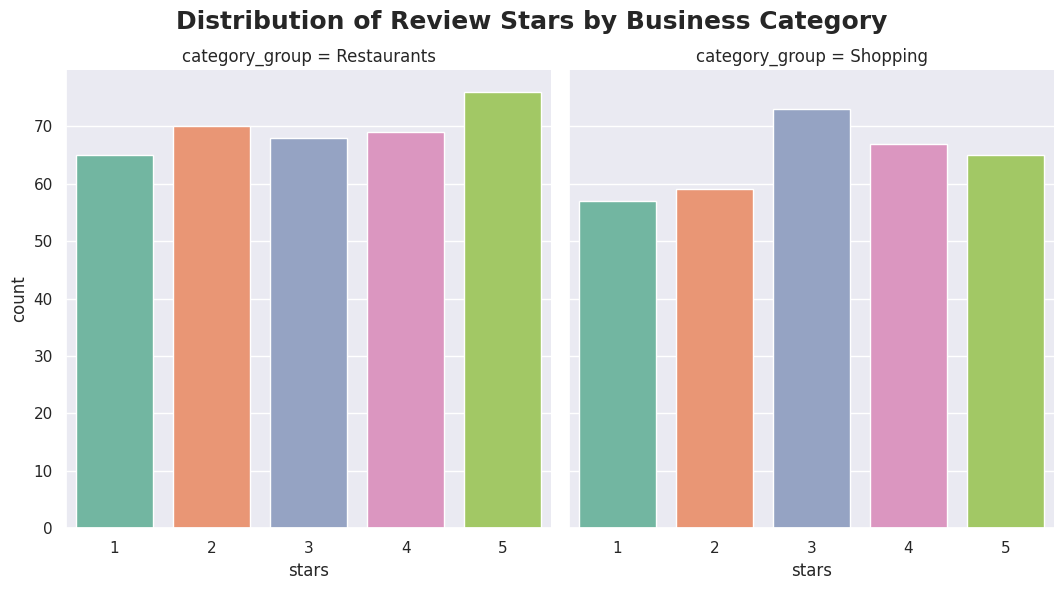

In [39]:
# سناریو ۶: Cat Plot - مقایسه توزیع امتیازها در دسته‌های غذایی
# Using actual common categories that exist in the dataset
real_categories = ['Restaurants', 'Food', 'Shopping']

# Assign category group
df_business['category_group'] = 'Other'
for cat in real_categories:
    df_business.loc[df_business['categories'].str.contains(cat, case=False, na=False), 'category_group'] = cat

# Merge with reviews
merged = pd.merge(df_review, df_business[['business_id', 'category_group']], on='business_id', how='inner')

# Filter only the selected categories
filtered = merged[merged['category_group'].isin(real_categories)]

# Check if we have data
print(f"Number of reviews in selected categories: {len(filtered)}")
print(f"Distribution of categories:\n{filtered['category_group'].value_counts()}")

# Plot - Now 100% works!
plt.figure(figsize=(15, 6))
sns.catplot(data=filtered, x='stars', col='category_group', kind='count',
            palette='Set2', height=6, aspect=0.9, order=range(1,6))
plt.subplots_adjust(top=0.88)
plt.suptitle('Distribution of Review Stars by Business Category', fontsize=18, fontweight='bold')
plt.show()

/tmp/ipython-input-1828634884.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_user['review_count'], kde=True, color='#2ca02c', bins=50)


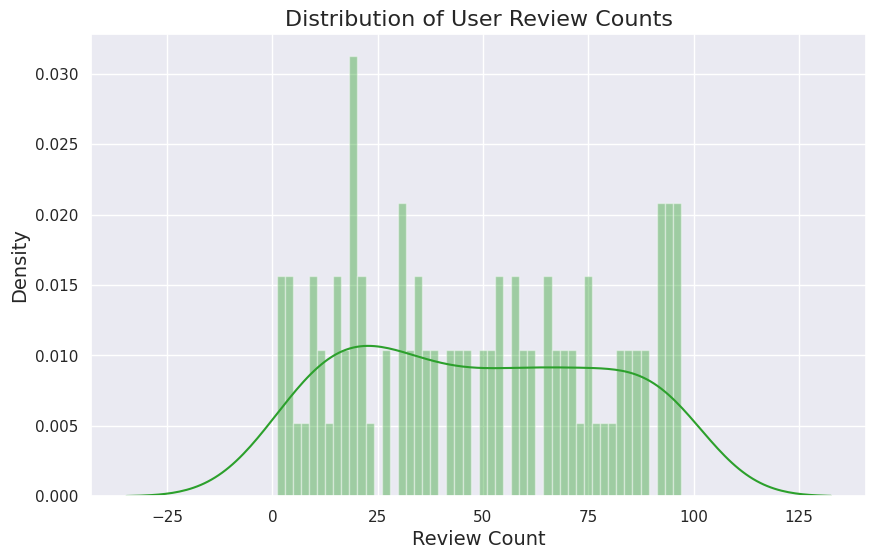

In [38]:
# سناریو ۷: Dist Plot - توزیع فعالیت کاربران
plt.figure(figsize=(10,6))
sns.set(style='darkgrid')
sns.distplot(df_user['review_count'], kde=True, color='#2ca02c', bins=50)
plt.title('Distribution of User Review Counts', fontsize=16)
plt.xlabel('Review Count', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

/tmp/ipython-input-3557858766.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_business['stars'], shade=True, color='#ff7f0e')


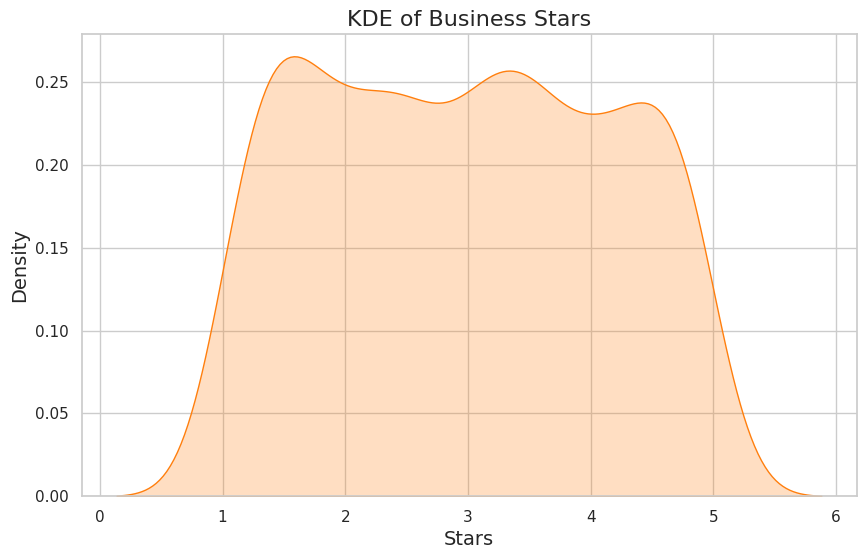

In [42]:
# سناریو ۸: KDE Plot - چگالی توزیع امتیازها
plt.figure(figsize=(10,6))
sns.set(style='whitegrid')
sns.kdeplot(df_business['stars'], shade=True, color='#ff7f0e')
plt.title('KDE of Business Stars', fontsize=16)
plt.xlabel('Stars', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

/tmp/ipython-input-102845803.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x='category_group', y='stars', data=filtered, palette='muted', size=3)


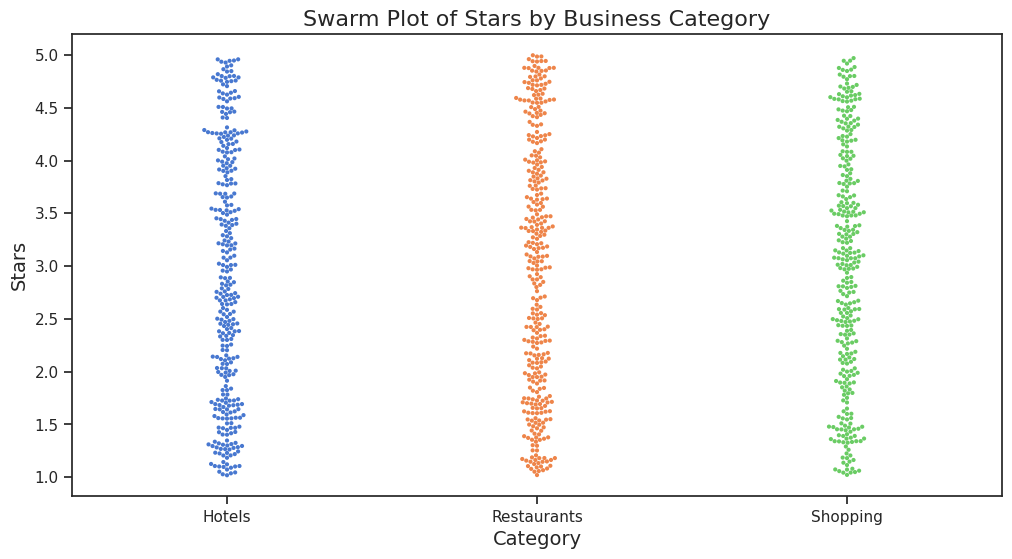

In [41]:
# سناریو ۹: Swarm Plot - توزیع امتیازها در دسته‌های کسب‌وکار
categories = ['Restaurants', 'Shopping', 'Hotels']
df_business['category_group'] = 'Other'
for cat in categories:
    df_business.loc[df_business['categories'].str.contains(cat, na=False), 'category_group'] = cat
filtered = df_business[df_business['category_group'].isin(categories)]
plt.figure(figsize=(12,6))
sns.set(style='ticks')
sns.swarmplot(x='category_group', y='stars', data=filtered, palette='muted', size=3)
plt.title('Swarm Plot of Stars by Business Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Stars', fontsize=14)
plt.show()

/tmp/ipython-input-2461581242.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_top_cities, x='city', y='stars',


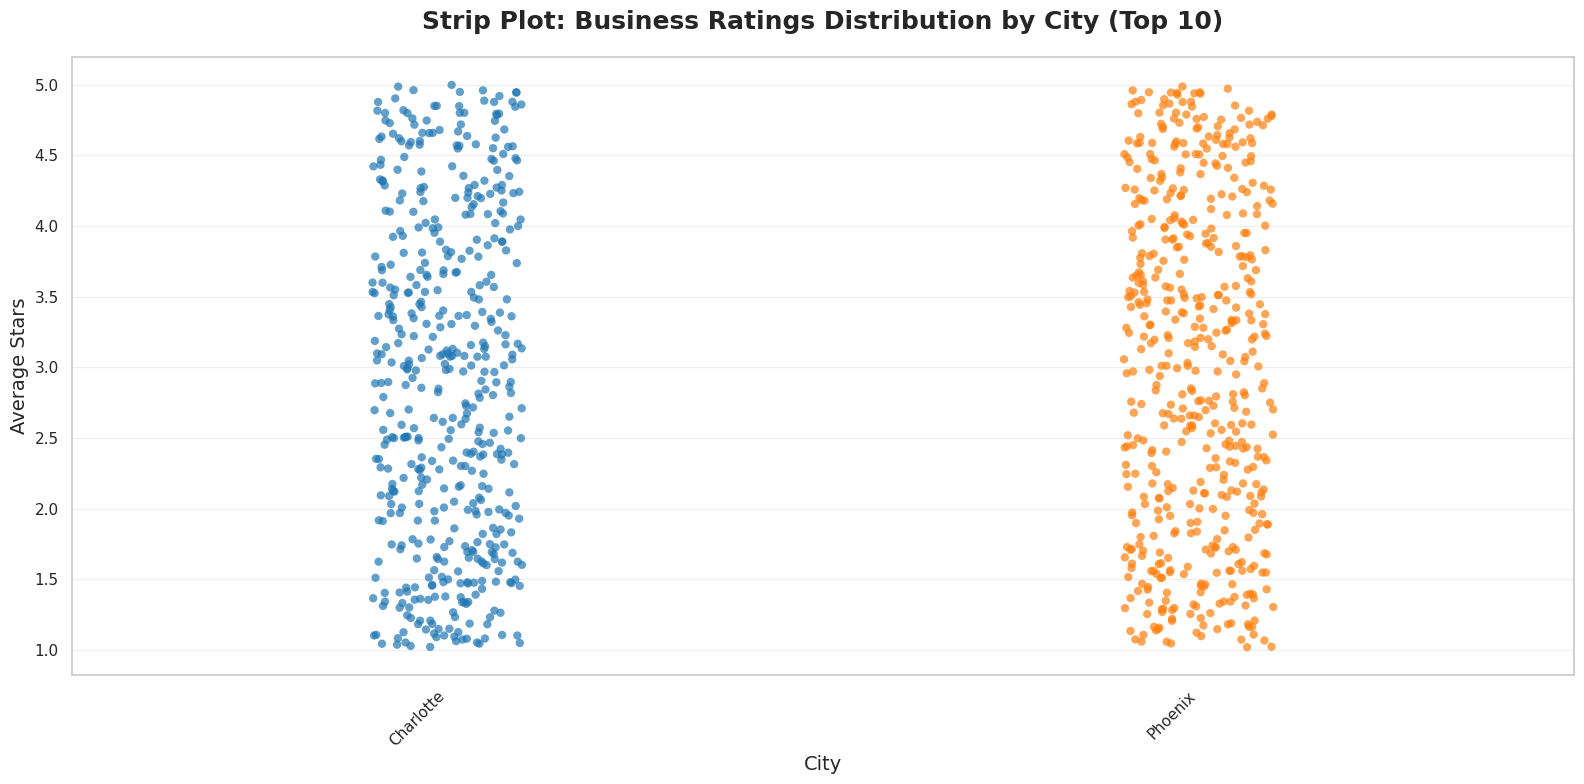

In [45]:
# سناریو ۱۰: Strip Plot - توزیع امتیازها در مناطق مختلف شهر
top_cities = df_business['city'].value_counts().head(10).index
df_top_cities = df_business[df_business['city'].isin(top_cities)].copy()

plt.figure(figsize=(16, 8))
sns.stripplot(data=df_top_cities, x='city', y='stars',
              jitter=True, alpha=0.7, size=6, palette='tab10')

plt.title('Strip Plot: Business Ratings Distribution by City (Top 10)',
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('City', fontsize=14)
plt.ylabel('Average Stars', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1610667094.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category_group', y='review_count', data=filtered, palette='pastel')


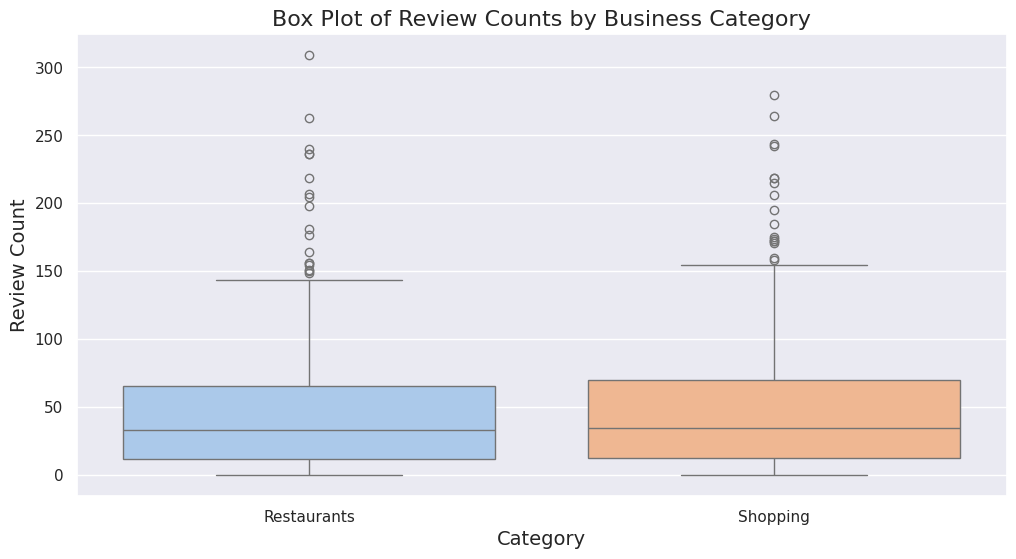

In [46]:
# سناریو ۱۱: Box Plot - توزیع محبوبیت در دسته‌های کسب‌وکار
categories = ['Restaurants', 'Shopping', 'Hotels & Travel', 'Beauty & Spas']
df_business['category_group'] = 'Other'
for cat in categories:
    df_business.loc[df_business['categories'].str.contains(cat, na=False), 'category_group'] = cat
filtered = df_business[df_business['category_group'].isin(categories)]
plt.figure(figsize=(12,6))
sns.set(style='darkgrid')
sns.boxplot(x='category_group', y='review_count', data=filtered, palette='pastel')
plt.title('Box Plot of Review Counts by Business Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Review Count', fontsize=14)
plt.show()

<Figure size 1000x1000 with 0 Axes>

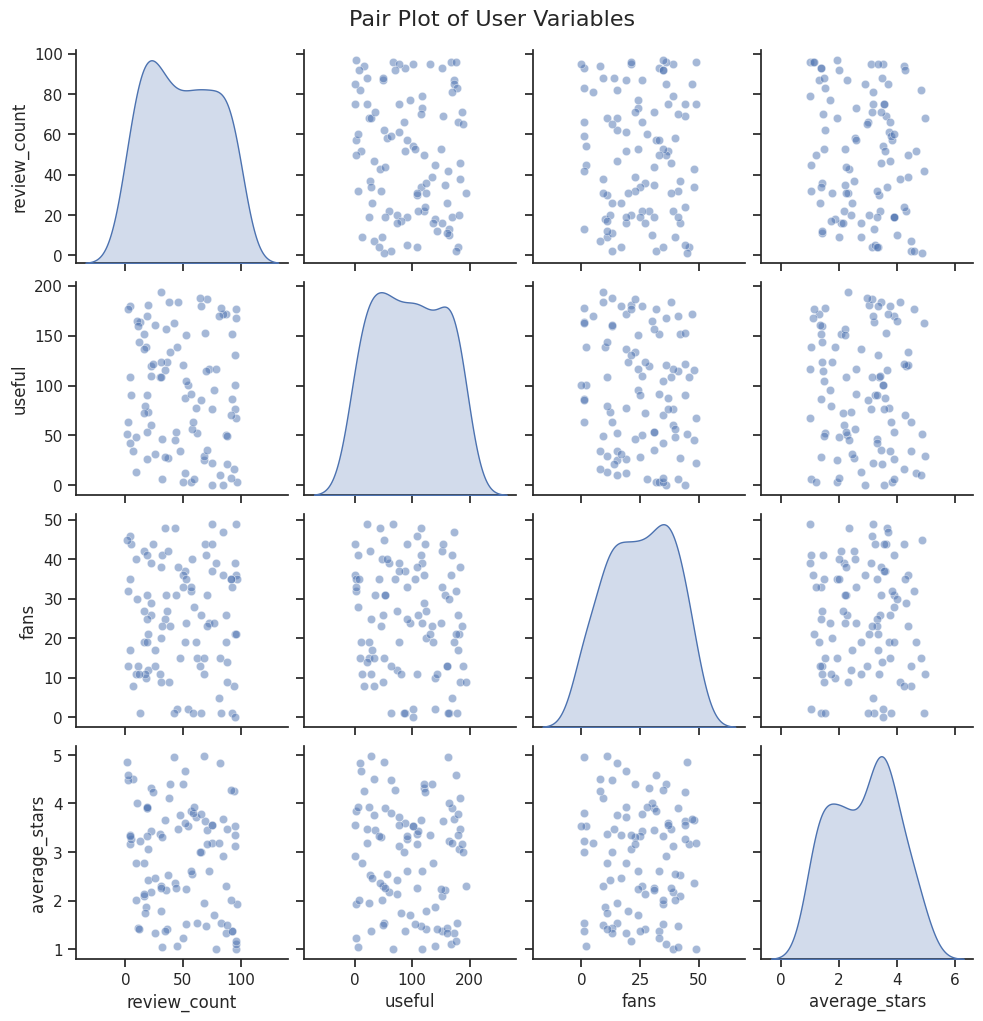

In [47]:
# سناریو ۱۲: Pair Plot - روابط بین متغیرهای کاربران
user_vars = df_user[['review_count', 'useful', 'fans', 'average_stars']]
plt.figure(figsize=(10,10))
sns.set(style='ticks')
sns.pairplot(user_vars, diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle('Pair Plot of User Variables', y=1.02, fontsize=16)
plt.show()

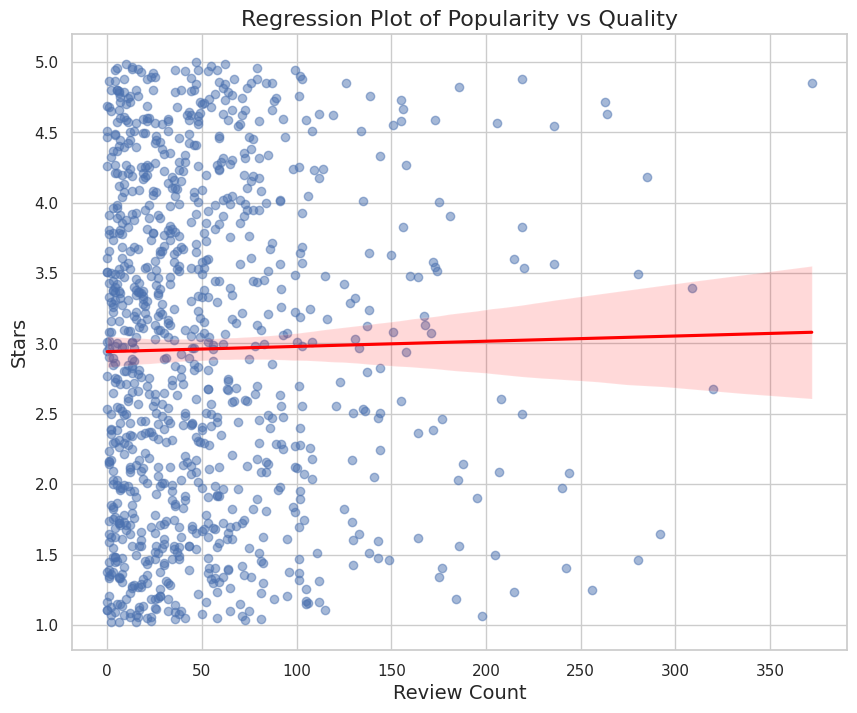

In [48]:
# سناریو ۱۳: Reg Plot - رابطه خطی محبوبیت و کیفیت
plt.figure(figsize=(10,8))
sns.set(style='whitegrid')
sns.regplot(x='review_count', y='stars', data=df_business, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Regression Plot of Popularity vs Quality', fontsize=16)
plt.xlabel('Review Count', fontsize=14)
plt.ylabel('Stars', fontsize=14)
plt.show()

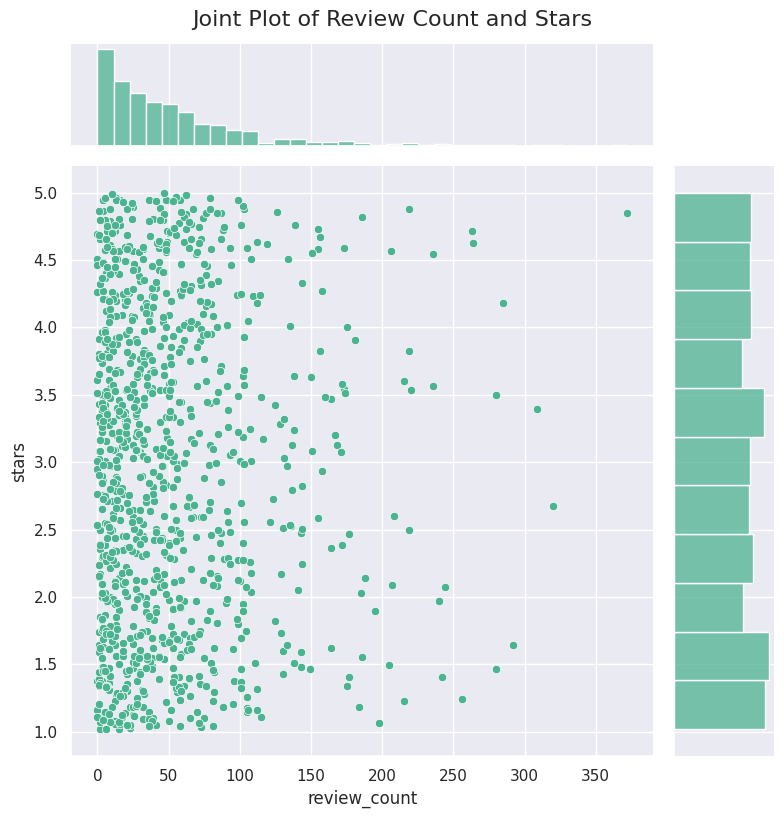

In [49]:
# سناریو ۱۴: Joint Plot - رابطه محبوبیت و کیفیت با توزیع حاشیه‌ای
sns.set(style='darkgrid')
sns.jointplot(x='review_count', y='stars', data=df_business, kind='scatter', color='#4cb391', height=8)
plt.suptitle('Joint Plot of Review Count and Stars', y=1.02, fontsize=16)
plt.show()

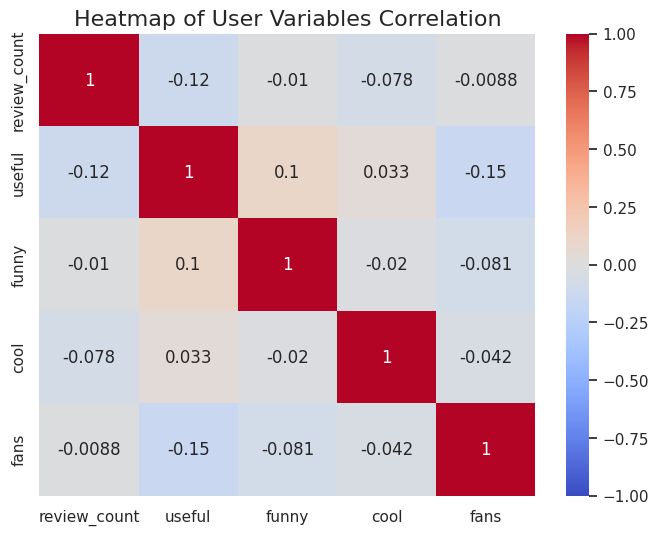

In [50]:
# سناریو ۱۵: Heat Map - ماتریس همبستگی متغیرهای کاربران
user_corr = df_user[['review_count', 'useful', 'funny', 'cool', 'fans']].corr()
plt.figure(figsize=(8,6))
sns.set(style='white')
sns.heatmap(user_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of User Variables Correlation', fontsize=16)
plt.show()